# K-Nearest Neighbours Regressor from Scratch

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Loading Data
Retrieved from [Kaggle - Diamonds](https://www.kaggle.com/datasets/shivam2503/diamonds)

**price**: Price in US dollars ($326 - $18,823)

**carat**: Weight of the diamond (0.2 - 5.01)

**cut**: Quality of the cut (Fair, Good, Very Good, Premium, Ideal)

**color**: Diamond colour, from J (worst) to D (best)

**clarity**: Measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

**x**: Length in mm (0 - 10.74)

**y**: Width in mm (0 - 58.9)

**z**: Depth in mm (0 - 31.8)

**depth**: Total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43-79)

**table**: Width of top of diamond relative to widest point (43--95)

In [2]:
df = pd.read_csv('diamonds.csv')
df = df.drop('Unnamed: 0', axis = 1)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## 2. Data Preprocessing

### 1. Deal with outliers
- Boxplot to identify numerical outliers.
- Winsorisation or capping to handle extreme values, if necessary.

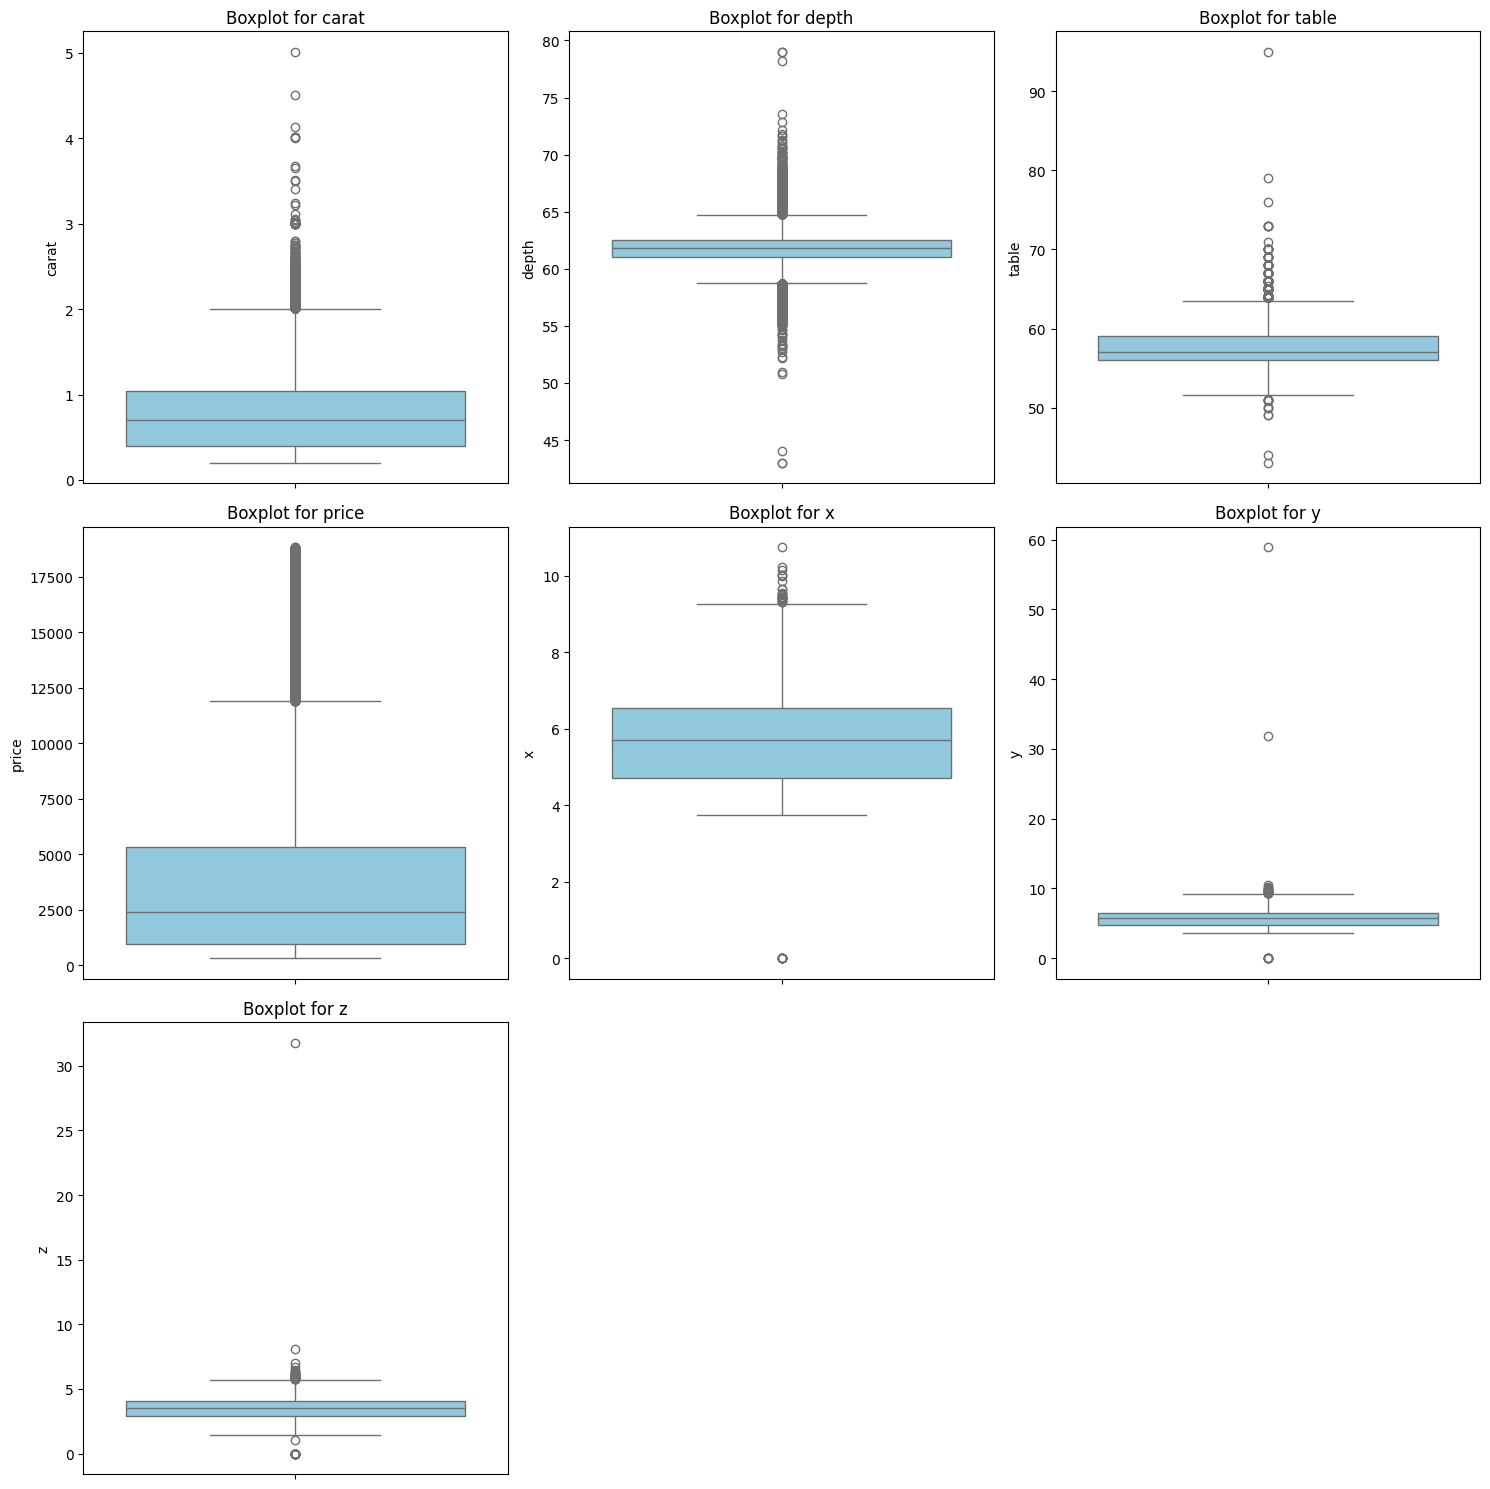

In [3]:
def plot_boxplots(df: pd.DataFrame) -> None:
    """
    Generate boxplots for each numerical column in the dataset to visualize outliers.
    
    Parameters:
        df (pd.DataFrame): The input dataframe.
    """
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    num_columns = len(numerical_columns)

    # Create subplots for boxplots
    fig, axes = plt.subplots(nrows=(num_columns + 2) // 3, ncols=3, figsize=(15, 5 * ((num_columns + 2) // 3)))
    axes = axes.flatten()

    for i, column in enumerate(numerical_columns):
        sns.boxplot(data=df, y=column, ax=axes[i], color='skyblue')
        axes[i].set_title(f'Boxplot for {column}')
        axes[i].set_ylabel(column)
        axes[i].set_xlabel('')

    # Remove unused subplots if any
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

plot_boxplots(df)

$Q1 =$ 25th percentile

$Q3 =$ 75th percentile

$IQR =$ Interquartile Range (50% at the middle) $= Q3 - Q1$

Lower bound $= Q1 - 1.5 \times IQR$

Upper bound $= Q3 + 1.5 \times IQR$

In [4]:
def remove_outliers_iqr(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove outliers from all numerical columns in the dataframe using the IQR method.

    Parameters:
        df (pd.DataFrame): The input dataframe.

    Returns:
        pd.DataFrame: DataFrame with outliers removed from all numerical columns.
    """
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    for column in numerical_columns:
        Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
        Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile range

        lower_bound = Q1 - 1.5 * IQR  # Lower bound for outliers
        upper_bound = Q3 + 1.5 * IQR  # Upper bound for outliers

        # Filter out rows with outliers
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df

# Call the function to remove outliers
df = remove_outliers_iqr(df)

### 2. Handle Categorical Features
Encoding Categorical Features:
- **cut**: Ordinal encoding (Fair < Good < Very Good < Premium < Ideal).
- **color**: Ordinal encoding (J < I < H < G < F < E < D).
- **clarity**: Ordinal encoding (I1 < SI2 < SI1 < VS2 < VS1 < VVS2 < VVS1 < IF).

In [5]:
def ordinal_encode(data: list[str], levels: list[str]) -> np.ndarray:
    """
    Perform ordinal encoding for a categorical feature.

    Parameters:
        data (list[str]): List of categorical values.
        levels (list[str]): Ordered list of unique levels in the desired order.

    Returns:
        np.ndarray: Ordinally encoded array.
    """
    level_map = {level: i for i, level in enumerate(levels)}
    print(level_map)
    return np.array([level_map[val] for val in data])

In [6]:
# Define categorical and continuous features
categorical_features = {
    'cut': ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],
    'color': ['J', 'I', 'H', 'G', 'F', 'E', 'D'],
    'clarity': ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
}

# Process categorical features
for feature, levels in categorical_features.items():
    df[feature] = ordinal_encode(df[feature], levels)
df[['cut', 'color', 'clarity']].head(10)

{'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
{'J': 0, 'I': 1, 'H': 2, 'G': 3, 'F': 4, 'E': 5, 'D': 6}
{'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}


,cut,color,clarity
0,4,5,1
1,3,5,2
3,3,1,3
4,1,0,1
5,2,0,5
6,2,1,6
7,2,2,2
9,2,2,4
10,1,0,2
11,4,0,4


### 3. Handle Continuous Features
Continuous features have varying ranges, and distance-based algorithms like KNN are sensitive to these differences.
- **price** (326 – 18,823): Standardise. Large range with potential outliers.
- **carat** (0.2 – 5.01): Standardise to handle outliers and maintain Gaussian-like distribution.
- **x, y, z** (0 – 10.74, 0 – 58.9, 0 – 31.8): Standardise. Widely different ranges and potential outliers.
- **depth** (43 – 79): Standardise as it’s a percentage, and differences might be subtle.
- **table** (43 – 95): Standardise for consistency across the dataset.

Standardisation centers data around the mean with unit variance, reducing the impact of outliers and differences in scale. This is suitable for KNN regression as it ensures fair weight across features in distance calculations. Standardisation transforms the data to have:

1. Mean = 0, which will become a centre value.
2. Standard Deviation = 1, making sure the spread of data is scaled.

The formula is:
\begin{align*}
z = \dfrac{x - \mu}{\sigma}
\end{align*}

where:

$x$: Original data value.

$\mu$: Mean of the feature.

$\sigma$: Standard deviation of the feature.

In [7]:
def standardise(data: np.ndarray) -> np.ndarray:
    """
    Standardise the dataset.

    Parameters:
        data (np.ndarray): A 2D NumPy array where each column is a feature.

    Returns:
        np.ndarray: Standardised dataset with mean 0 and variance 1.
    """
    data_mean = np.mean(data, axis=0)
    data_std = np.std(data, axis=0)
    return (data - data_mean) / data_std

In [8]:
continuous_features = ['carat', 'x', 'y', 'z', 'depth', 'table']
df[continuous_features] = standardise(df[continuous_features].values)

### 4. Normalise After Encoding & Scaling Features
If the final dataset contains a mix of scaled and encoded features, normalise the final feature matrix to make sure all features fall within a similar range for better distance calculation. The equation for min-max normalisation is:

\begin{align*}
x_{normalised} = \dfrac{x - min(X)}{max(X) - min(X)}
\end{align*}

In [9]:
def normalise(data: np.ndarray) -> np.ndarray:
    """
    Normalise the dataset to range [0, 1].

    Parameters:
        data (np.ndarray): A 2D NumPy array where each column is a feature.

    Returns:
        np.ndarray: Normalised dataset.
    """
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    return (data - min_val) / (max_val - min_val)
df[continuous_features] = normalise(df[continuous_features].values)
df[continuous_features]

,carat,x,y,z,depth,table
0,0.016667,0.048458,0.065359,0.277929,0.446429,0.260870
1,0.005556,0.035242,0.034858,0.245232,0.142857,0.782609
3,0.050000,0.103524,0.119826,0.332425,0.607143,0.521739
4,0.061111,0.134361,0.145969,0.365123,0.767857,0.521739
5,0.022222,0.046256,0.061002,0.291553,0.678571,0.434783
...,...,...,...,...,...,...
53935,0.288889,0.444934,0.453159,0.569482,0.321429,0.434783
53936,0.288889,0.431718,0.450980,0.599455,0.732143,0.260870
53937,0.277778,0.425110,0.435730,0.585831,0.678571,0.695652
53938,0.366667,0.533040,0.531590,0.634877,0.357143,0.521739


## 3. Euclidean Distance

### Euclidean Distance

Euclidean distance is the most widely used distance metric in KNN algorithms, which measures the shortest distance between two points as a straight line in multi-dimensional space.

\begin{align*}
\sqrt{\sum_{i=1}^{n} (a_i - b_i)^2}
\end{align*}

In [10]:
# Calculate Eucliean Distance
def calculate_euclidean(a: float, b: float) -> float:
    return np.sqrt(np.sum((a - b) ** 2))

## 4. Train Test Split
Train test split is a fundamental model validation technique in machine learning. It divides a dataset into two separate portions: a **training set** used to train a model, and a **testing set** used to evaluate how well the model can perform on unseen data. 

The typical split ratio is 80% for training and 20% for testing, though this can vary (70/30 or 90/10 are also common). The key principle is that the test set must remain completely separated during model training process, and should never be used to make decisions about the model or tune parameters. 

The split is usually done randomly to ensure both sets are representative of the overall dataset, and many libraries (such as scikit-learn) provide build-in functions that handle this process automatically while maintaining proper randomisation.

In [11]:
def train_test_split(X: np.array, y: np.array, test_size: float = 0.2,
                     random_state: int = None) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Split arrays or matrices into random train and test subsets.

    Parameters:
        X (np.array): Input features, a 2D array with rows (samples) and columns (features).
        y (np.array): Target values/labels, a 1D array with rows (samples).
        test_size (float): Proportion of the dataset to include in the test split. Must be between 0.0 and 1.0. default = 0.2
        random_state (int): Seed for the random number generator to ensure reproducible results. default = None

    Returns:
        tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        A tuple containing:
            - X_train (np.ndarray): Training set features.
            - X_test (np.ndarray): Testing set features.
            - y_train (np.ndarray): Training set target values.
            - y_test (np.ndarray): Testing set target values.
    """
    # Set a random seed if it exists
    if random_state:
        np.random.seed(random_state)

    # Create a list of numbers from 0 to len(X)
    indices = np.arange(len(X))

    # Shuffle the indices
    np.random.shuffle(indices)

    # Define the size of our test data from len(X)
    test_size = int(test_size * len(X))

    # Generate indices for test and train data
    test_indices: list[int] = indices[:test_size]
    train_indices: list[int] = indices[test_size:]

    # Return: X_train, X_test, y_train, y_test
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

## 5. KNN Regressor

In [12]:
class KNN_Regressor:
    """
    A simple K-Nearest Neighbours (KNN) regressor.
    """

    def __init__(self, k=3) -> None:
        """
        Initialise the model with k, the number of neighbours.

        Parameters: 
            k (int): The number of nearest neighbours to consider for classification. default = 3.
        """
        self.k = k

    def fit(self, X_train: np.array, y_train: np.array) -> None:
        """
        Fit the training data.

        Parameters:
            X_train (np.array): Training features, a 2D array with rows (samples) and columns (features).
            y_train (np.array): Training labels, a 1D array of labels corresponding to X_train.
        """
        self.X_train = X_train
        self.y_train = y_train

    def calculate_distance(self, x1: float, x2: float) -> float:
        """
        Calculate the Euclidean distance between two points.

        Parameters:
            x1 (float): First point.
            x2 (float): Second point.

        Returns:
            float: The Euclidean distance between x1 and x2.
        """
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def predict(self, X_test: np.array) -> np.array:
        """
        Predict the labels for X_test.

        Parameters:
            X_test (np.array): Test features, a 2D array with rows (samples) and columns (features).

        Returns:
            np.array: Predicted labels for each test sample.
        """
        return np.array([self._predict(x_test)[0] for x_test in X_test])

    def _predict(self, x_test: np.array) -> tuple[str, np.array, list[float]]:
        """
        Predict the label for a single test sample and provide additional detals.

        Parameters:
            x_test (np.array): A single test sample,

        Returns:
            tuple: A tuple containing:
            - str: The most common label among the k nearest neighbours.
            - np.array: Indices of the k nearest neighbours.
            - list[str]: Labels of the k nearest neighbours.
        """
        distance_list: list[float] = [calculate_euclidean(
            x_test, x_train) for x_train in self.X_train]

        k_neighbours: np.array = np.argsort(distance_list)[:self.k]
        k_neighbours_values: list[float] = [
            self.y_train[i] for i in k_neighbours]
        mean_values = np.mean(k_neighbours_values)
        return mean_values, k_neighbours

## 6. Evaluate KNN Regressor Model


### 1. Mean Squared Error (MSE)
Mean Squared Error measures the average squared difference between predicted ($\hat y$) and actual ($y$) values. Large errors are penalised heavily. Smaller MSE indicates better predictions.

\begin{align*}
MSE = \dfrac{1}{n} \sum_{i=1}^{n}(\hat y_{i} = y_{i})^2
\end{align*}


In [ ]:
def calculate_MSE(y_true: np.array, y_pred: np.array) -> float:
    return np.mean(y_true - y_pred) ** 2

### 2. Root Mean Squared Error (RMSE)
Square root of MSE. It provides error in the same unit as the target variable ($y$) and easier to interpret.

\begin{align*}
RMSE = \sqrt{(MSE)}
\end{align*}

In [ ]:
def calculate_RMSE(y_true: np.array, y_pred: np.array) -> float:
    return np.sqrt(np.mean(y_true - y_pred) ** 2)

### 4. Mean Absolute Error (MAE)
Mean Absolute Error measures the average absolute difference between predicted ($\hat y$) and actual ($y$) values. It is less sensitive to outliers than MSE. Smaller MAE indicates better predictions.

\begin{align*}
MAE = \dfrac{1}{n} \sum_{i=1}^{n}|\hat y_{i} = y_{i}|
\end{align*}

In [ ]:
def calculate_MAE(y_true: np.array, y_pred: np.array) -> float:
    return np.mean(np.abs(y_true - y_pred))

### 5. R-squared($R^2$)

R-squared indicated the proportion of variance in the dependent variable that is predictable from the independent variables. Value ranges from 0 to 1. Closer to 1 indicates a better fit.



Residual Sum of Squares ($SS_{residual}$): 
\begin{align*}
SS_{residual} = \sum_{i=1}^{n} (y_{i} - \hat y_{i})^{2}
\end{align*}

Total Sum of Squares ($SS_{total}$): 
\begin{align*}
SS_{total} = \sum_{i=1}^{n} (y_{i} - \bar y_{i})^{2}
\end{align*}

$R^2$ is computed as:

\begin{align*}

R^2 = 1 - \dfrac{SS_{residual}}{SS_{total}} = 1 - \dfrac{\sum_{i=1}^{n} (y_{i} - \hat y_{i})^{2}}{\sum_{i=1}^{n} (y_{i} - \bar y_{i})^{2}}

\end{align*}

where:

$y$: Actual target values ($y_{true}$).

$\bar y$: Mean of the actual target values.

$\hat y$: Precicted target values.

In [ ]:
def calculate_r2(y_true: np.array, y_pred: np.array) -> float:
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

In [ ]:
MSE_list, RMSE_list, MAE_list, R2_list = [], [], [], []
X = df.drop(columns=['price']).values
y = df['price'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train KNN regressor, make predictions and evaluate the model for different k values.
for k in range(1, 15):
    knn_reg = KNN_Regressor(k=k)
    knn_reg.fit(X_train, y_train)
    y_pred = knn_reg.predict(X_test)

    mse = calculate_MSE(y_test, y_pred)
    rmse = calculate_RMSE(y_test, y_pred)
    mae = calculate_MAE(y_test, y_pred)
    r2 = calculate_r2(y_test, y_pred)
    print(f"For k = {k}, MSE: {mse}")
    print(f"For k = {k}, RMSE: {rmse}")
    print(f"For k = {k}, MAE: {mae}")
    print(f"For k = {k}, R2: {r2}")